Chapter 3
==============


## Opning the black box of MCMC
之前的两章隐藏了PyMC3的内部机制，以及更加通用的马尔科夫链蒙特卡洛方法（MCMC）。

### The Bayesian landscape
当我们用贝叶斯推断有$N$个未知参数的问题时，我们隐式地创建了一个$N$维的先验分布空间。与空间相关联的一个是一个额外的维度，我们可以将其描述为位于空间顶部的表面或曲线，其反映了特定点的先验概率。空间上的表面是由我们的先验分布定义的。如果我们有两个未知数$p_1$和$p_2$，并且两者的先验都是$\text{Uniform}(0, 5)$，则创建的空间是床都为5的平方，并且表面是一个平面（每个点都有相同的概率性）。

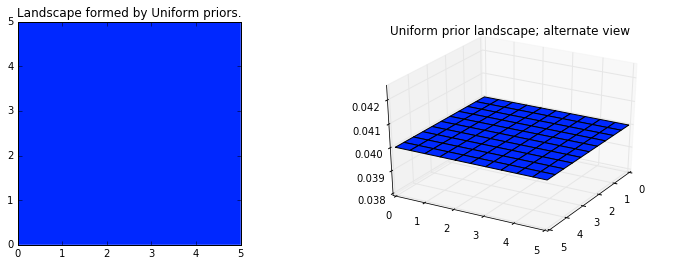

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

若是先验分布是$Exp(3)$和$Exp(4)$，那么空间将变为2D平面上的所有正数，并且由先验分布生成的表面看起来像是从点(0,0)开始并且流过所有正数的瀑布。

下面的图做了可视化。颜色越红越黑，表明越高的先验概率值在那个位置。相反地，蓝色较深的区域表明那个位置的先验概率值越低。

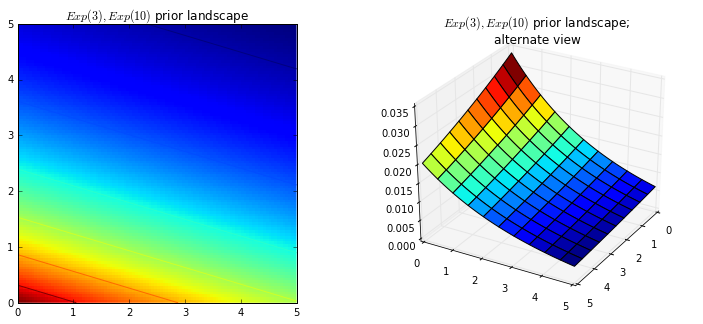

In [2]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

这些是2D空间中的简单示例，我们的大脑可以很好滴理解表面。在实际中，我们的先验分布所产生的空间和表面维度可以更高。

如果这些表面描述了我们对未知量的先验分布，那么在我们收集到观测数据XX之后，先验空间会发生什么变化？数据XX不会改变空间，而是通过拉伸先验分布表面的网格来改变空间的表面，从而反映真实参数可能存在的位置。更多的数据意味着更多的拉伸，与新形成的形状相比，我们的原始形状变得微不足道。较少的数据下，我们的原始形状才有更多的表现力。无论如何，所得到的表面描述了后验分布。

再次，我必须强调，不幸的是，不可能在高维度可视化概率分布。对于二维例子，数据基本上推动了原始的表面，形成了*高山形状*。通过先验概率分布来检查观察到的数据在某些区域中提高后验概率的趋势，所以较低的先验概率意味着更多的阻力。因此，在上述双指数先验分布情况下，在(0,0)角附近可能爆发出一个山（或者多个山）将比在(5,5)角附近爆发山的概率要高很多，因为有更多的阻力（低先验概率）在(5,5)附近。峰值反映了可能发现真实参数值的后验概率。重要的是，如果先验分布的概率已经为0，则对应位置将不再会有后验概率出现。

假设上述先验分布表示的是两个泊松分布的各自参数$\lambda$。我们观测一些数据后可视化其分布。

In [3]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 1): [[2 7]]


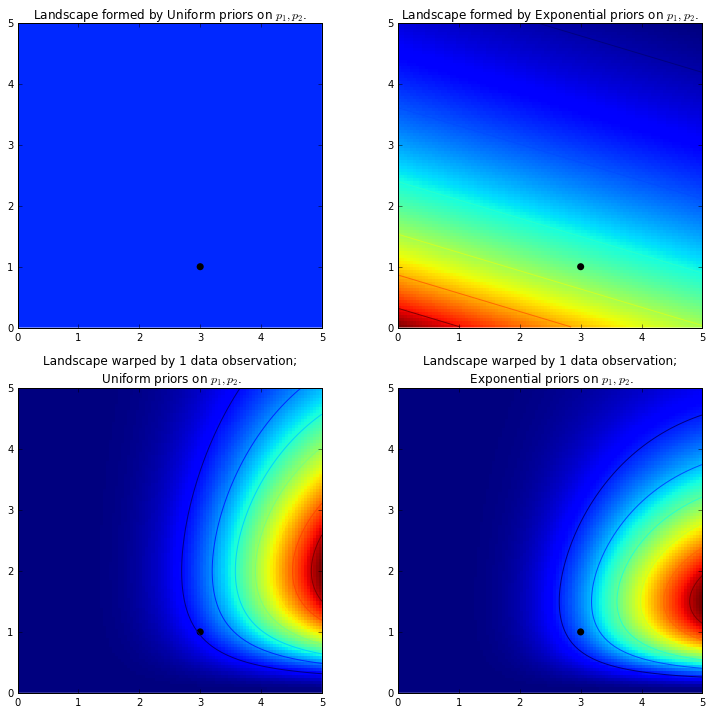

In [4]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

注意到后验分布看起来彼此不同，尽管在两种情况下观测到的数据是相同的，原因如下：注意到在指数先验分布，在右上部分只有很少的后验权重，这是因为其先验权重很低。另一方面，uniform后验会在右上放置较多的权重，因为其先验权重在哪里都一样大。

还要注意到最高点，对应着最深的红色，在指数分布中更加偏向(0,0），这是由于其先验分布有更多的权重在(0,0)附近。

### Exploring the landscape using the MCMC
我们应该探索由先验分布表面产生的变形了的后验分布空间，并且观测数据是如何发现后验高山的。然而，我们不能用天真的方法探索空间：任何计算机科学家会告诉你，探索N维空间的代价是N的指数级计算量：探索空间会快速的随着N的增加而爆炸（见[维度灾难](http://en.wikipedia.org/wiki/Curse_of_dimensionality)）。我们有希望找到这些隐藏的山峰？MCMC背后的想法是对这个空间进行智能的探索。说“探索”意味着我们在寻找某个特定的点，这可能是用词不准，因为我们寻找的是一个范围。

回想一下，MCMC从后验分布返回样本，而不是分布本身。将我们的山区比喻扩展到极限，MCMC执行的任务类似于反复询问“我发现的这个石子是从我要寻找的山区得到的可能性有多大呢？”并通过得到的成千上万的石子重构原来的山来完成这个任务。在MCMC和PyMC3行话中，返回的石子序列就是样本，累计起来称为轨迹traces.

当我们说MCMC智能搜索时，我实际上是说MCMC有很大的希望收敛在高后验分布的区域中。MCMC通过探索临近的位置并移动到更高概率的区域来做到这一点。再次，也许“收敛”对描述MCMC过程来说不准确。收敛通常暗示着朝向空间中的一个点移动，但是MCMC是向空间中的一个区域移动，并且在该区域随机游走，并从中采集样本。

#### 为什么要采样成千上万次？
首先，返回给用户成千上万的结果看起来像是描述后验分布的一个低效方法。我则认为这实际上是非常高效的方法。考虑其他可能性：
1. 返回一个可以描述“山脉”的数学公式，它可以描述在一个N维空间中的任意峰谷。
2. 返回分布的山峰，这在数学上是可能的，并且在最高点对应对未知量的最有可能的估计也是合理的。这样忽略了分布的形状，这个我们之前讨论过，形状对于决定未知量的后验分布置信度是非常重要的。

除了计算能力的限制，返回样本的最大原始可能是我们可以轻松使用*大数定理*来解决其他棘手的问题。我将这个推迟到下章讨论。通过成千上万个样本，我们可以通过在直方图中组织它们来重建后验分布表面

### Algorithm to perform MCMC
有一系列算法来执行MCMC过程。这些算法中的大部分可以抽象的表达为：（数学细节可在附录中找到）
1. 从当前位置开始。
2. 移动到一个新的位置（查看当前位置附近的石子）。
3. 根据位置对观测数据和先验分布的服从程度，决定接受或拒绝新的位置。（询问石子是否可能来自山）
4.   1. 如果接受新位置：移动到新位置，返回到步骤1.
    2. 否则不移动到新位置，返回到步骤1.
5. 经过大量的迭代，返回所有接受的位置。

通过这种方式，我们大体上向着后验分布存在的区域移动，并在移动过程中收集样本。一旦我们到达高后验分布，我们可以很容易的收集样本，因为它们都来自于后验分布。

如果MCMC算法的当前位置处于极低概率区域，这通常在算法开始时出现，算法将会移动到可能不属于后验分布但是比当前位置附近都好的位置。因此，算法的第一步移动不能反映后验分布。

在上述的伪代码中，注意只有当前位置的信息（新位置只是探索当前位置的周围）。我们可以描述这个性质为无记忆性，即算法不关心它如何到达当前位置。

### Other approximation solutions to the posterior
除了MCMC，也有其他的算法可以得出后验分布。拉普拉斯逼近使用简单函数来逼近后验分布。一种更先进的方法是变分贝叶斯。这三种方法，拉普拉斯笔记，变分贝叶斯，古典MCMC都有其优缺点。这里我们只关注MCMC。

##### Example: Unsupervised Clustering using a Mixture Model
假设我们给定下面的数据集：

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


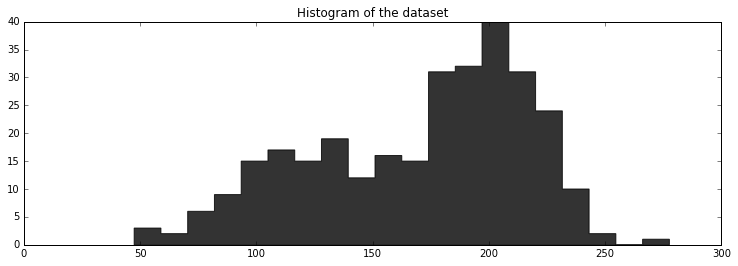

In [5]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

数据表明什么？看起来数据具有双峰形式，也就是说，它似乎有两个峰，一个接近120，另一个在200附近。也许这个数据集中有两个聚类。

该数据集是上一章数据生成建模技术的一个很好的例子。我们可以提出如何创建数据。我建议以下数据生成算法：

1. 对于每个数据点，选择簇为1的概率为p，否则选择簇2。 
2. 从参数$\mu_i$和$\sigma_i$的正态分布采样随机变量，其中在步骤1中选择了$i$。 
3. 重复1和2。

该算法将产生与观察到的数据集相似的数据，因此我们选择它作为我们的模型。当然，我们不知道$p$或者正态分布的参数。因此，我们必须推断或学习这些未知数。

将数据点分配给对应簇的适当方法是使用PyMC3`Categorical`随机变量。它的参数是一个长度为k的概率数组，且数组元素的和必须为1，并且其元素的`value`属性是一个根据概率阵列随机选择的范围在0到k-1之间的正数随机值。(在我们这里$k=2$)。在先验概率分布，我们不知道分配到簇1的概率是多少，所以我们在(0,1)区间形成一个uniform变量，称为$p_1$，所以属于簇2的概率为$p_2=1-p_1$。

不幸的是，我们不能将`[p1, p2]`指派给`Categorical`变量。PyMC3使用Theano在底层构建模型，所以我们需要使用`theano.tensor.stack()`来绑定$p_1$和$p_2$到一个theano可以理解的向量。我们将此向量传递到`Categorical`变量，同时指定`testval`为我们认为的参数起始点。

In [6]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical('assignment', p,
                               shape=data.shape[0],
                               testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


prior assignment, with p = 0.50:
[0 0 0 1 1 1 1 1 0 1]


查看上面的数据集，我猜两个正太分布的标准差是不一样的。为了保持对标准差的无知性，我们将要初始化模型，其中用Uniform[0,100]来表示。我用将使用一行PyMC3代码来表示模型中的两个标准差，这样写并不会导致两个随机变量有什么相关性出现。

    sds = pm.Uniform("sds", 0, 100, shape=2)
    
我们还需要指定簇的中心点的先验分布。中心点其实就是这些正太分布的$\mu$参数。它们的先验可以通过正太分布来建模。观察数据，我有对于两个中心点位置的大致看法——一个在120附近，另一个在190附近。尽管我不确定这种肉眼的估计值，我仍旧将变量的初始值设置为它们。

In [7]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [0 0 0 1] ...
Assigned center:  [ 120.  120.  120.  190.] ...
Assigned standard deviation:  [ 50.  50.  50.  50.]


我们在`Model()`的上下文中进行的任何抽样行为只能在此上下文的模型中完成。我们将通过定义抽样方法（`Metropolis()`用于连续值，`ElemwiseCategorical()`用于离散值）来探索我们定义的取值空间。我们要用这些采样方法来通过使用方法`sample(iterations, step)`来探索空间，其中`iterations`是你需要算法执行的次数，`step`是你想如何处理每次的算法执行。我们组合`Metropolis()`和`ElemwiseCategorical()`在`step`中，并且迭代25000次。

In [8]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25500/25500 [46:52<00:00,  8.46it/s]


我们已经将所有的变量的轨迹存储到`trace`变量中。这些路径是由未知参数(中心，精度和$p$)的采样值构成的。每个变量的单独路径由我们在模型定义时给出该变量的PyMC3变量名索引得到。例如`trace['sds']`将返回一个numpy数组对象，然后我们可以像任何其他numpy数组对象那样进行索引和切片操作。

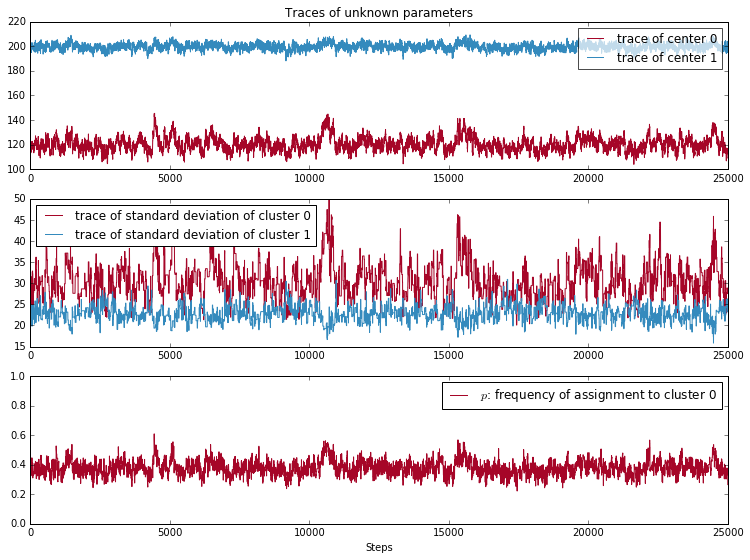

In [9]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

注意下面的特点：
1. 迹线收敛，而不是单点，而是可能点的分布。这是MCMC算法中的*收敛*。 
2. 使用前几千个点的推论是一个坏主意，因为它们与我们感兴趣的最终分布无关。因此，在使用样本推断之前丢弃这些样本是一个好主意。我们把这个时期称之为*老化期burn-in*。 
3. 轨迹显示为在某个位置附近随机的“走”，也就是说，路径明显与以前的位置相关。这是好的也是坏的。现在的位置和以前的位置将会始终存在相关性，但其中太多意味着我们不能很好地探索空间。这将在本章后面的诊断部分详细介绍。

为了进一步收敛，我们将执行更多的MCMC步骤。在上述MCMC的伪代码算法中，唯一重要的位置是当前位置（新位置在当前位置附近进行探索），隐式存储为`trace`对象的一部分。要从我们结束探索的地方继续探索的话，我们将已经存储的`trace`传递给具有相同`step`值的`sample()`函数。我们已经计算的值不会被覆盖。这样可以确保我们的采样以与停止的方式相同的方式继续进行。

我们将再次采样MCMC五万次，并将以下进度显示出来：

In [10]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50500/50500 [1:34:43<00:00,  8.47it/s]


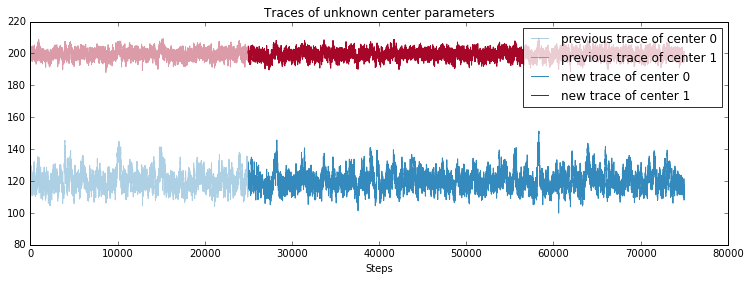

In [11]:
figsize(12.5, 4)
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

#### Cluster Investigation
我们没有忘记我们的主要挑战：识别簇。我们已经确定了未知量的后验分布。我们绘制中心点变量和标准差变量的后验分布。

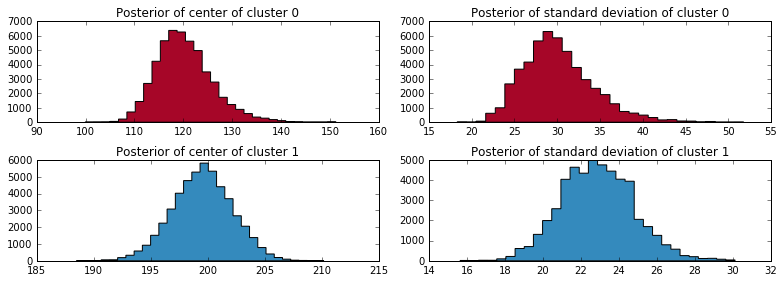

In [12]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

MCMC算法提出，两个簇中最有可能的中心分别接近120和200。类似的推论可以应用于标准偏差。 

我们还给出了`trace['assignment']`中存在的数据点标签的后验分布。下面是这个的可视化。 y轴表示每个数据点的后标签的子样本。 x轴是数据点排序后的值。红色正方形是对簇1的分配，蓝色方块是对簇0的分配。

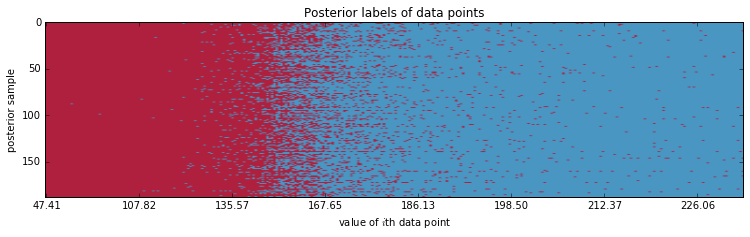

In [16]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");


看上面的图，似乎最大的不确定性在150到170之间。上面的图略有错误地表示事物，因为x轴不是一个真实的尺度（它显示第$i$个排序的数据点的值）。以下更清楚的图表，我们估计属于标签0和1的每个数据点的*频率*。

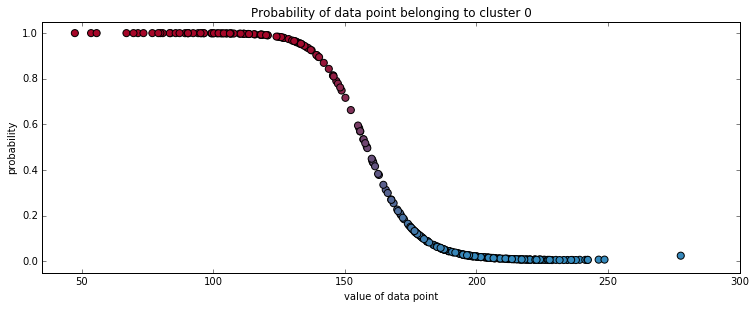

In [18]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

尽管我们使用正态分布来建模簇，但是我们并没有得到最适合数据的唯一的正态分布（无论我们的最佳定义是什么），而是正太分布的参数值的分布。我们如何才能选择一对均值和方差，来确定最佳匹配的正太分布？ 

一个快速肮脏的方式（我们将在第5章中看到其理论属性很好），是使用后验分布的均值。下面我们用正态密度函数，使用后验分布的均值作为选择的参数到我们观察到的数据：

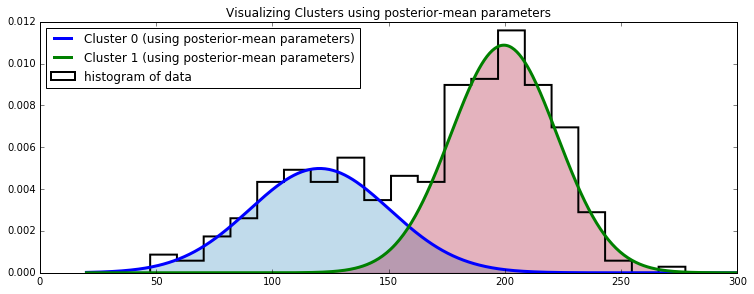

In [17]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

### Important: Don't mix posterior samples
在上面的例子中，一个可能的（尽管不大可能）的情况是，簇0具有非常大的标准差，而簇1具有小的标准偏差。这仍然可以满足证据，尽管不如我们原来的推论。或者，两个分布都不可能具有小的标准差，因为观测数据根本不支持这一假设。因此，两个标准差依赖于彼此：如果一个较小，则另一个必须很大。事实上，*所有未知量*都以相似的方式相关。例如，如果标准差很大，则平均值具有更宽的实现空间。相反，小的标准偏差将平均值限制在较小的区域。

在MCMC期间，我们返回代表来自未知后验的样本的向量。不同向量的元素不能一起使用，因为这将破坏上述逻辑：也许一个样本已经返回了聚类1具有小的标准偏差，因此该样本中的所有其他变量将合并并相应地进行调整。可以很容易避免这个问题，只是确保正确索引`trace`。

另一个小例子来说明这一点。假设$x$和$y$两个变量与$x + y = 10$相关。我们将$x$建模为具有平均值4的正态随机变量，并探索500个样本。

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10500/10500 [00:02<00:00, 4918.03it/s]


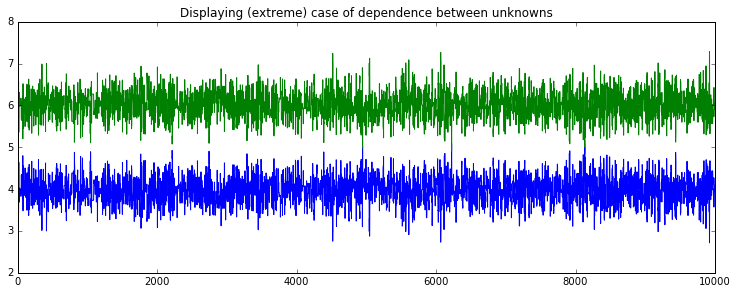

In [19]:
import pymc3 as pm

with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");

可以看出，这两个变量并不是无关的，除非$i = j$，否则将$x$的第二个样本添加到$y$的第j个样本是错误的。

#### Returning to Clustering: Prediction
上述聚类可以推广到$k$个簇。选择$k = 2$可以让我们更好地可视化MCMC，并检查一些非常有趣的图。 

预测会怎么样？假设我们观察一个新的数据点，说$x = 175$，我们希望将其标注到一个簇。简单地将其分配给距离簇中心更近的簇是愚蠢的，因为这忽略了簇的标准偏差，从上图可以看出，这个考虑是非常重要的。更正式地：我们对于将$x = 175$分配给簇1的$概率$（我们不能确定标签）感兴趣。将$x$的分配表示为$L_x$，$x$等于0或1，我们对$P(L_x = 1 \;|\; x = 175 )$感兴趣。

计算这个的简单方法是使用附加的数据点重新运行上述MCMC。这种方法的缺点是推断出每个新的数据点都很慢。或者，我们可以尝试一个不太精确，但更快的方法。

我们将使用贝叶斯定理。如果你记得的话贝叶斯定理看起来像：

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

在我们的例子中，$A$表示$L_x = 1$，$X$是我们有的证据：我们观察到$x = 175$。对于我们的后验分布$( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$的特定参数的样本集，我们有兴趣问“$x$在簇1中的概率大于集群0中的概率是多少？”，其中概率取决于所选择的参数。

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

由于分母是相等的，它们可以被忽略（由于计算$P(x = 175)$可能很困难）。

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$


In [20]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())

Probability of belonging to cluster 1: 0.00816


给我们一个概率而不是标签是一件非常有用的事情。而不是天真的。
  L = 1 if prob > 0.5 else 0
我们可以使用损失函数来优化我们的猜测，这是整个第五章所致力的。

### Using MAP to improve convergence
如果你自己运行上述示例，你可能已经注意到我们的结果不一致：也许你的簇更加分散，或者更少分散。原因是我们的踪迹是MCMC算法起始值的函数。 

可以通过数学表明，通过执行许多步骤让MCMC运行得足够长，算法应该已经忘记其初始位置。事实上，这就是说MCMC达到了收敛（实际上我们永远不会实现总体收敛）。因此，如果我们观察到不同的后验分析，可能是因为我们的MCMC还没有完全收敛，我们不应该从未收敛的地方使用样本（我们应该使用更大的老化期）。

事实上，不好的起始值可以阻止任何收敛，或者显着减慢。理想情况下，我们希望从我们的概率的高峰开始，因为这正是后验分布存在的地方。因此，如果我们从“高峰”开始，就可以避免长时间的老化期和不正确的推论。一般来说，我们把这个“高峰”称为最大后验概率值，或者更简单的称为MAP。 

当然，我们不知道MAP在哪里。 PyMC3提供了一个功能，即使没有找到MAP位置也可以近似。在PyMC3主命名空间中是`find_MAP1`函数。如果你在`Model()`的上下文中调用此函数，它将计算MAP，然后将其传递到`pm.sample()`作为起始参数。

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

`find_MAP()`函数具有允许用户选择使用哪种优化算法的灵活性（毕竟，这是一个优化问题：我们正在寻找最大化我们的后验分布的值），因为并不是所有的优化算法都是相等的。函数调用中的默认优化算法是Broyden-Fletcher-Goldfarb-Shanno（BFGS）算法，用于查找对数后验的最大值。作为替代方案，你可以使用`scipy.optimize`模块中的其他优化算法。例如，您可以通过调用`find_MAP(fmin = scipy.optimize.fmin_powell)`来使用Powell的方法，这是PyMC博主Abraham Flaxman [1]的最爱。默认值足够好，但如果收敛速度较慢或不能保证，请随时尝试使用Powell的方法或其他算法。

MAP也可以用作推理问题的解决方案，数学上它是未知数的最有可能的价值。但是如本章前面所述，此位置忽略了真实参数值的不确定性并且不返回参数的分布。

#### Speaking of the burn-in period
即使我们在采样之前使用`find_MAP()`，只是为了安全起见，决定一个老化周期仍然是个好主意。我们不能再像在PyMC2中一样使用`sample()`函数中的`burn`参数自动丢弃样本，但是通过数组切片简单地丢弃跟踪的开始部分就足够简单了。由于不知道马尔科夫链何时完全收敛，一个很好的经验法则是丢弃*前面一半*的样本，有时候长达90％的样本可能会长时间运行。继续上面的聚类示例，新代码将如下所示：

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, start=start)
    
    burned_trace = trace[50000:]

## Diagnosing Convergence

### Autocorrelation
自相关是衡量一系列数与自身相关性的量度。测量值1.0表示是完美的正相关，0表示没有自相关，-1表示完全的负相关。如果你熟悉标准*相关性*，那么自相关就只是一系列$X_\tau$在时间$t$与自己在时间$t - k$的相关性：

$$R(k) = Corr( x_t, x_{t-k} ) $$

For example, consider the two series:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

which have example paths like:

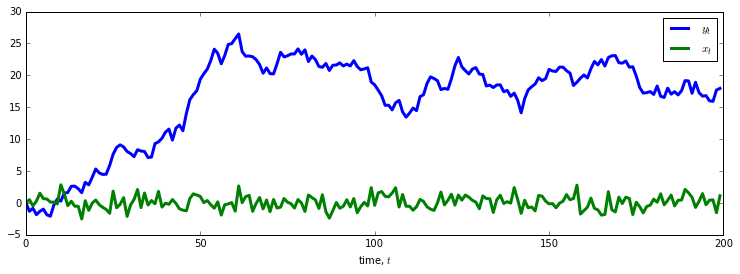

In [21]:
figsize(12.5, 4)

import pymc3 as pm
x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();


思考自相关的一种方法是“如果我在时间点$s$知道序列的位置，它可以帮助我知道序列在时间$t$的位置吗？”在序列$x_t$中，答案是否定的。通过构建，$x_t$是随机变量。如果我告诉你$x_2 = 0.5$，你能给我关于$x_3$的更好猜测？不能。 

另一方面，$y_t$是自相关的。通过构建，如果我知道$y_2 = 10$，我可以非常有信心，$y_3$不会离10很远。同样，我甚至可以对$y_4$做一个（不太自信的猜测）：它可能不会接近0或20，但值5不太可能。我可以对$y_5$做一个类似的论证，但是再一次，我更不自信了。以这个逻辑结论，我们必须承认，作为$k$，时间点之间的滞后增加了自相关性的下降。我们可以看出这一点：

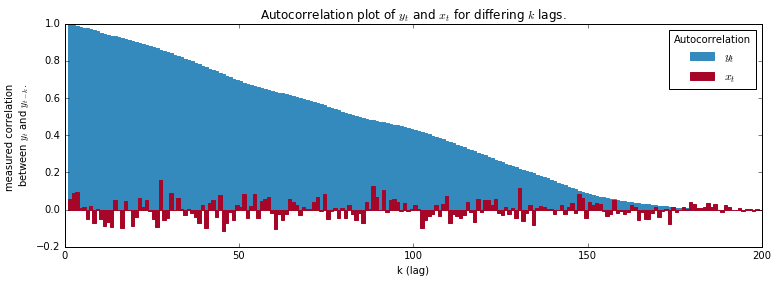

In [22]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

请注意，随着$k$的增加，$y_t$的自相关性从一个非常高的点降低。与$x_t$的自相关性相比，它看起来像噪声（它真的是），因此我们可以得出结论，本序列中不存在自相关。

#### How does this relate to MCMC convergence?
通过MCMC算法的性质，我们将始终返回显式存在自相关性的样本（这是因为你从当前位置,移动一步，到当前附近的位置）。

探索这个空间的一条链（没有迂回探索的前提下？)会显示非常高的自相关性。视觉上，如果跟踪似乎像一条河流蜿蜒曲折，而不是安定下来，那么这个链条将会有很高的自相关性。 

这并不暗示着收敛的MCMC具有低自相关性。因此，自相关度低并不是收敛所必需的，但它是充分的。PyMC3在`plots`绘图模块中具有内置的自相关绘图功能。

### Thinning
如果后验样本之间存在高自相关性，则可能会出现另一个问题。许多后续进行的算法要求样本彼此*独立*。这可以通过将每个第$n$个样本返回给用户来解决或至少减少，从而达到消除一些自相关。下面我们对$y_t$执行不同稀疏水平的自相关图：

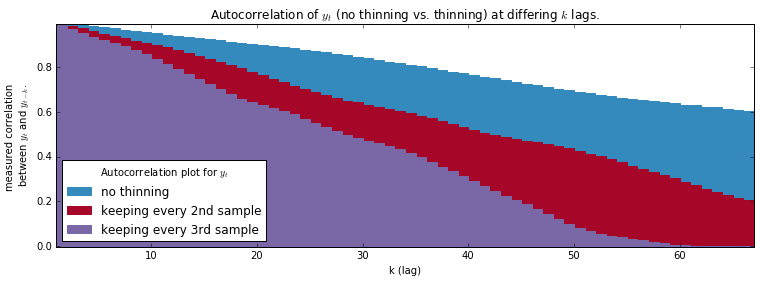

In [23]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

随着更薄，自相关性下降更快。有一个折衷：更高的稀疏需要更多的MCMC迭代次数来实现相同数量的返回样本。例如，1万个样本是被10万个样本以10个为单位稀释得到的（尽管后者的自相关性较小）。 

什么稀释量是适合的？返回的样本将始终表现出一些自相关性，无论变薄多少。只要自相关趋于零，你就差不多可以了。通常稀释10倍以上是不必要的。

### `pymc3.plots`
每次执行MCMC时，似乎都必须手动创建直方图，自相关图和跟踪图。PyMC3的作者已经提供了一个可视化工具，仅为此目的。 

`pymc3.plots`模块包含一些你可能会发现有用的不同绘图函数。对于其中包含的每个不同的绘图函数，你只需传递从抽样返回的`trace`以及你感兴趣的变量的列表`varnames`。该模块可为你提供每个变量的自相关图和其后验分布图，还有其踪迹等等。 

下面我们使用该工具绘制簇的中心。

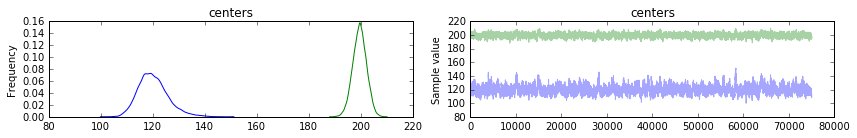

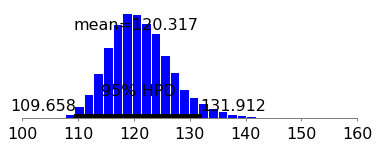

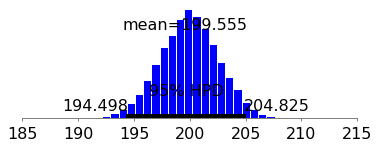

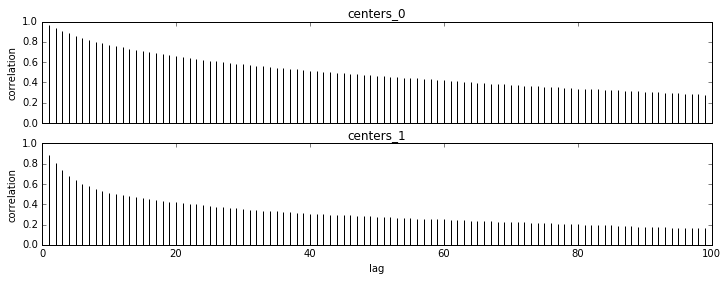

In [24]:
pm.plots.traceplot(trace=trace, varnames=["centers"])
pm.plots.plot_posterior(trace=trace["centers"][:,0])
pm.plots.plot_posterior(trace=trace["centers"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

第一个绘图函数给出了`centers`变量的后验密度分布。`trace`图对于检查可能导致无法收敛的“弯曲”属性是很有效的。密度图给了我们每个未知量的分布形状的想法，但最好单独看一下它们。 

第二个绘图功能为我们提供了具有几个附加特征的样本的直方图。中心的文字叠加显示了我们的后验均值，这是后验分布的一个很好的总结。由水平黑线叠加标记的间隔表示95％可信区间，有时称为最高后验密度区间，不要与95％置信区间混淆。我们不会进入后者，但是前者可以被解释为“参数有95％的机会落入到这个区间”。在将结果传达给他人时，说明这个区间是非常重要的。学习贝叶斯方法的目的之一是清楚地了解我们对未知量的不确定性。结合后验均值，95％可信区间提供可靠的间隔来传达未知（由平均值提供）和不确定性（由间隔宽度表示）的可能位置。 

标题为`center_0`和`center_1`的最后一个图是生成的自相关图，与上面显示的相似。

## Useful tips for MCMC
如果不是MCMC的计算困难，贝叶斯推理将是事实的推论。事实上，MCMC是导致大多数用户远离实践贝叶斯推断的原因。下面我提出一些很好的启发式来帮助MCMC引擎的收敛和加速：

### Intelligent starting values
在后验分布附近开始MCMC算法是非常好的，使得开始正确采样的时间将不会太长。我们可以通过在`Stochastic`变量创建中通过指定`testval`参数来告诉我们认为的后验分布的方式来帮助算法。在许多情况下，我们可以对参数产生合理的猜测。例如，如果我们有来自正态分布的数据，并且我们希望估计$\mu$，则一个良好的起始值将是数据的平均值。

     mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )
     
对于模型中的大多数参数，有一个频繁的估计。这些估计是我们的MCMC算法的一个很好的起始值。当然，这并不总是对所有变量都适用，但包括尽可能多的适当的初始值总是一个好主意。即使你的猜测是错误的，MCMC仍然会收敛于适当的分布，所以没有失去什么东西。

MAP尝试给MCMC提供良好的初始值。那么为什么要用户指定初始值呢？因为即使使用MAP，给出一个的良好值也可以帮助它找到最大后验估计值。

同样重要的是，*不好的初始值*是PyMC3中的主要错误的来源，可能会损害收敛。
#### Priors
如果先验选择不佳，MCMC算法可能不会收敛，或至少难以收敛。考虑如果先验分布甚至不包含正确的参数可能会发生什么：先验分布中将0概率分配给未知量，因此后验分布将为0概率。这可能导致病理结果。 

因此，最好仔细选择先验。通常，缺乏覆盖或样本拥挤到边界的证据意味着所选择的先验分布有错误（参见下面统计计算的民间定理）。

#### Covariance matrices and eliminating parameters

### The Folk Theorem of Statistical Computing

>   *If you are having computational problems, probably your model is wrong.*

## Conclusion
PyMC3提供了非常强大的后台来执行贝叶斯推理，主要是因为将MCMC的内部机制抽象出来方便用户使用。尽管如此，必须小心的建模，以确保你得到的推论不会因为MCMC的迭代性而产生偏见。

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()